# WeatherPy
----

### Analysis
* As expected, the weather becomes significantly warmer as one approaches the equator (0 Deg. Latitude). More interestingly, however, is the fact that the southern hemisphere tends to be warmer this time of year than the northern hemisphere. This may be due to the tilt of the earth.
* There is no strong relationship between latitude and cloudiness. However, it is interesting to see that a strong band of cities sits at 0, 80, and 100% cloudiness.
* There is no strong relationship between latitude and wind speed. However, in northern hemispheres there is a flurry of cities with over 20 mph of wind.

---

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
%matplotlib inline

# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import datetime

# Import API key
from api_keys import api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "./output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)


In [2]:
"""
Function to build the url by city name

param1: city_name: the cityname

returns: the fully formed url for the OpenWeatherMap API with the api_key and the city_name and units as imperial as query params
"""
def build_url_by_city_name(city_name):
    base_url = f'http://api.openweathermap.org/data/2.5/weather?appid={api_key}'
    return f"{base_url}&q={city_name}&units=imperial"

## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

636

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
#Create an empty list
l = []

start_msg = 'Beginning Data Retrieval'
end_msg = 'Data Retrieval Complete'
print(start_msg)
print('-'*len(start_msg))

batch_size = 60
wait_time = 60
record_number = 0
record_group_number = 0

for i in range(0, len(cities), batch_size):
    record_group_number = record_group_number + 1
    for j in range(i, batch_size + i): 
        if j < len(cities):
            record_number = j + 1
            json_data = requests.get(build_url_by_city_name(cities[j])).json()
            if json_data['cod'] == '429': 
                break
            elif json_data['cod'] == '404':
                print(f"City not found. Skipping {cities[j]} ...") 
            else:
                print(f"Processing Record {record_number} of Set {record_group_number} | {json_data['name']}")
                #Create an empty dictionary to store what we want from the json_data 
                d = {}
                d['id'] = json_data['id']
                d['City'] = json_data['name']
                d['Country'] = json_data['sys']['country']
                d['Date'] = json_data['dt']
                d['Humidity'] = json_data['main']['humidity']
                d['Lat'] = json_data['coord']['lat']
                d['Lng'] = json_data['coord']['lon']
                d['Cloudiness'] = json_data['clouds']['all']
                d['Max Temp'] = json_data['main']['temp_max']
                d['Wind Speed'] = json_data['wind']['speed']
                l.append(d)
    #sleep for 1 minute between batch calls
    time.sleep(wait_time)

print('-'*len(end_msg)) 
print(end_msg)
print('-'*len(end_msg))                  

Beginning Data Retrieval
------------------------
Processing Record 1 of Set 1 | Mwinilunga
Processing Record 2 of Set 1 | Tucuman
Processing Record 3 of Set 1 | Sault Sainte Marie
Processing Record 4 of Set 1 | Iqaluit
Processing Record 5 of Set 1 | Castro
City not found. Skipping saleaula ...
Processing Record 7 of Set 1 | Port Hardy
City not found. Skipping louisbourg ...
Processing Record 9 of Set 1 | Punta Arenas
City not found. Skipping taolanaro ...
Processing Record 11 of Set 1 | Palmer
Processing Record 12 of Set 1 | George Town
City not found. Skipping tasbuget ...
Processing Record 14 of Set 1 | Hobart
Processing Record 15 of Set 1 | Vao
Processing Record 16 of Set 1 | Soure
Processing Record 17 of Set 1 | Mataura
Processing Record 18 of Set 1 | Koulikoro
Processing Record 19 of Set 1 | Huarmey
Processing Record 20 of Set 1 | Fallon
Processing Record 21 of Set 1 | Saint-Philippe
Processing Record 22 of Set 1 | Carnarvon
Processing Record 23 of Set 1 | New Norfolk
City not fo

Processing Record 199 of Set 4 | Lavumisa
Processing Record 200 of Set 4 | Bento Goncalves
Processing Record 201 of Set 5 | Zhangjiakou
Processing Record 202 of Set 5 | Bassar
Processing Record 203 of Set 5 | Cockburn Town
Processing Record 204 of Set 5 | Calama
City not found. Skipping ruatoria ...
City not found. Skipping gulshat ...
Processing Record 207 of Set 5 | Hilo
Processing Record 208 of Set 5 | Victoria
City not found. Skipping barentsburg ...
Processing Record 210 of Set 5 | Turtas
Processing Record 211 of Set 5 | Arraial do Cabo
Processing Record 212 of Set 5 | Pinhao
Processing Record 213 of Set 5 | Corn Island
Processing Record 214 of Set 5 | Severobaykalsk
Processing Record 215 of Set 5 | San Joaquin
Processing Record 216 of Set 5 | Pastavy
City not found. Skipping karauzyak ...
Processing Record 218 of Set 5 | Clyde River
Processing Record 219 of Set 5 | Aykhal
City not found. Skipping tapaua ...
Processing Record 221 of Set 5 | Kupang
Processing Record 222 of Set 5 | 

Processing Record 397 of Set 8 | Ugoofaaru
Processing Record 398 of Set 8 | Swan Hill
Processing Record 399 of Set 8 | Nortelandia
Processing Record 400 of Set 8 | Ancud
Processing Record 401 of Set 9 | Houston
Processing Record 402 of Set 9 | Eagle Pass
Processing Record 403 of Set 9 | Yumen
Processing Record 404 of Set 9 | Emerald
Processing Record 405 of Set 9 | Alyangula
Processing Record 406 of Set 9 | Ust-Tsilma
Processing Record 407 of Set 9 | Dezful
Processing Record 408 of Set 9 | Dongying
Processing Record 409 of Set 9 | Aromashevo
Processing Record 410 of Set 9 | Esperance
Processing Record 411 of Set 9 | Srednekolymsk
Processing Record 412 of Set 9 | Nantong
Processing Record 413 of Set 9 | Bagdarin
Processing Record 414 of Set 9 | Manono
Processing Record 415 of Set 9 | New London
Processing Record 416 of Set 9 | Chevilly-Larue
Processing Record 417 of Set 9 | Siderno
Processing Record 418 of Set 9 | Maceio
Processing Record 419 of Set 9 | Mindelo
Processing Record 420 of 

Processing Record 591 of Set 12 | Mago
Processing Record 592 of Set 12 | Povenets
Processing Record 593 of Set 12 | Iroquois Falls
Processing Record 594 of Set 12 | Lavrentiya
Processing Record 595 of Set 12 | Shache
Processing Record 596 of Set 12 | Waddan
Processing Record 597 of Set 12 | Burewala
Processing Record 598 of Set 12 | Margate
Processing Record 599 of Set 12 | Kangema
Processing Record 600 of Set 12 | Balabac
Processing Record 601 of Set 13 | Teya
Processing Record 602 of Set 13 | Bandarbeyla
Processing Record 603 of Set 13 | Namibe
Processing Record 604 of Set 13 | Batagay-Alyta
Processing Record 605 of Set 13 | Baghdad
Processing Record 606 of Set 13 | Lubao
Processing Record 607 of Set 13 | Griffith
Processing Record 608 of Set 13 | Los Llanos de Aridane
Processing Record 609 of Set 13 | Ixtapa
City not found. Skipping kegayli ...
Processing Record 611 of Set 13 | Codrington
Processing Record 612 of Set 13 | Wangaratta
Processing Record 613 of Set 13 | Sicuani
Processi

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [12]:
df = pd.DataFrame(l)
df.to_csv(output_data_file, index=False)
#df = pd.read_csv(output_data_file)
df.head()

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed,id
0,Mwinilunga,20,ZM,1543601655,88,-11.73,24.43,67.46,5.35,902620
1,Tucuman,0,PE,1543601655,33,-17.17,-70.89,73.81,5.06,3934608
2,Sault Sainte Marie,90,CA,1543600560,88,46.49,-84.36,32.00,3.36,5009004
3,Iqaluit,20,CA,1543597200,84,63.75,-68.52,6.80,5.82,5983720
4,Castro,20,CL,1543597200,47,-42.48,-73.76,59.00,12.75,3896218


### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [6]:
"""
Function to build the scatter plot based on the param values passed in

param1: x_axis
param2: y_axis
param3: title
param4: xlabel
param5. ylabel

"""
def build_scatter_plot(x_axis, y_axis, title, xlabel, ylabel):
    todays_date = datetime.date.today().strftime('%m/%d/%Y')
    plt.scatter(x=x_axis, y=y_axis, alpha=.75, edgecolors='black', linewidths=.75)
    plt.title(f"{title} ({todays_date})")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

#### Latitude vs. Temperature Plot

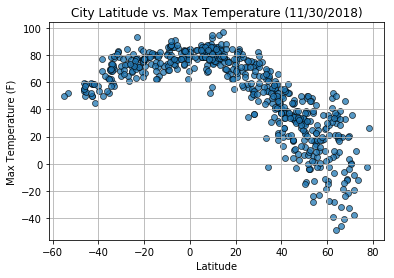

In [7]:
build_scatter_plot(x_axis=df['Lat']
                   , y_axis=df['Max Temp']
                   , title='City Latitude vs. Max Temperature'
                   , xlabel='Latitude'
                   , ylabel='Max Temperature (F)'
                  )    

#### Latitude vs. Humidity Plot

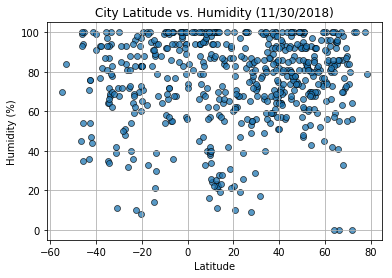

In [8]:
build_scatter_plot(x_axis=df['Lat']
                   , y_axis=df['Humidity']
                   , title='City Latitude vs. Humidity'
                   , xlabel='Latitude'
                   , ylabel='Humidity (%)')

#### Latitude vs. Cloudiness Plot

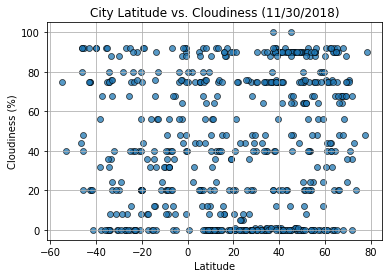

In [9]:
build_scatter_plot(x_axis=df['Lat']
                   , y_axis=df['Cloudiness']
                   , title='City Latitude vs. Cloudiness'
                   , xlabel='Latitude'
                   , ylabel='Cloudiness (%)'
                  )  

#### Latitude vs. Wind Speed Plot

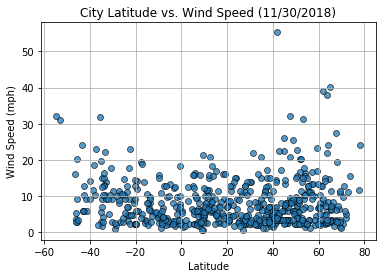

In [10]:
build_scatter_plot(x_axis=df['Lat']
                   , y_axis=df['Wind Speed']
                   , title='City Latitude vs. Wind Speed'
                   , xlabel='Latitude'
                   , ylabel='Wind Speed (mph)'
                  )  